# Telecom Churn Case Study
PG Diploma in Machine Learning and AI March 2018<br/>
Group Members
1. Reghuram Vasanthakumari
2. Sanjoy Krishna Ghosh
3. Dipesh Singhal
4. Naveen Bharadwaj

The analysis is divided into following parts<br/>
1. Filter high-value customers<br/>
2. Handlling The Missing Values<br/>
3. Derive new features<br/>
4. Splitting the Test and Train Data<br/>
5. PCA
6. Logistic Regression<br/>
7. SVM<br/>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Functions 
The space for user defined functions

In [2]:
def plot_triangular(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, annot=False, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [3]:
def plot_multiple_distributions(data, targets):
    scale = StandardScaler(copy=False)
    scaled_df = pd.DataFrame(scale.fit(data[targets]).transform(data[targets]), columns=targets)
    for target in targets:
        sns.distplot(scaled_df.loc[:, target], hist=False, rug=False, label=target)
    return None
    

In [65]:
import powerlaw
def power_law_analysis(data, targets):
    for target in targets:
        results = powerlaw.Fit(data.loc[:, target])
        print(results.power_law.alpha)
        print(results.power_law.xmin)
        R, p = results.distribution_compare('power_law', 'lognormal')

In [66]:
def plot_accuracy(scores, hyper_params):
    for hyper_param in hyper_params:
        hyper_param_name = 'param_'+hyper_param
        plt.figure()
        plt.plot(scores[hyper_param_name], 
         scores["mean_train_score"], 
         label="training accuracy")
        plt.plot(scores[hyper_param_name], 
         scores["mean_test_score"], 
         label="test accuracy")
        plt.xlabel(hyper_param)
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

   ## 1. Load the data
Load the churn data for the telecom provider

In [5]:
churn_data = pd.read_csv('telecom_churn_data.csv')

total_records = churn_data.shape[0]


## 2. Missing value treatment

In [6]:
missing_value_percentage = round(100 * churn_data.isnull().sum().sort_values(ascending=False) / total_records, 2)
missing_value_percentage[missing_value_percentage > 50.0]

count_rech_2g_6             74.85
date_of_last_rech_data_6    74.85
count_rech_3g_6             74.85
av_rech_amt_data_6          74.85
max_rech_data_6             74.85
total_rech_data_6           74.85
arpu_3g_6                   74.85
arpu_2g_6                   74.85
night_pck_user_6            74.85
fb_user_6                   74.85
arpu_3g_7                   74.43
count_rech_2g_7             74.43
fb_user_7                   74.43
count_rech_3g_7             74.43
arpu_2g_7                   74.43
av_rech_amt_data_7          74.43
max_rech_data_7             74.43
night_pck_user_7            74.43
total_rech_data_7           74.43
date_of_last_rech_data_7    74.43
night_pck_user_9            74.08
date_of_last_rech_data_9    74.08
fb_user_9                   74.08
arpu_2g_9                   74.08
max_rech_data_9             74.08
arpu_3g_9                   74.08
total_rech_data_9           74.08
av_rech_amt_data_9          74.08
count_rech_3g_9             74.08
count_rech_2g_

In [7]:
non_kpis_to_be_imputed =['max_rech_data_6', 'max_rech_data_7',  'max_rech_data_8', 'max_rech_data_9']
#This valuses doesnpt drive the KPI will replace by zero as per instruction
churn_data[non_kpis_to_be_imputed] = churn_data[non_kpis_to_be_imputed].fillna(0, axis=1)

#impute the categorical variable NaN with -1
cat_variables_to_be_imputed = ['night_pck_user_6', 'night_pck_user_7',
                               'night_pck_user_8', 'night_pck_user_9',
                               'fb_user_6', 'fb_user_7',
                               'fb_user_8', 'fb_user_9']
churn_data[cat_variables_to_be_imputed] = churn_data[cat_variables_to_be_imputed].fillna(-1, axis=1)

In [8]:
#date dependant missing values
kpis_imputed_wrt_date = dict( date_of_last_rech_data_6 = ['total_rech_data_6', 
                                                          'count_rech_2g_6', 
                                                          'count_rech_3g_6', 'av_rech_amt_data_6' ],
                             date_of_last_rech_data_7 = ['total_rech_data_7', 
                                                          'count_rech_2g_7', 
                                                          'count_rech_3g_7', 'av_rech_amt_data_7' ], 
                             date_of_last_rech_data_8 = ['total_rech_data_8', 
                                                          'count_rech_2g_8', 
                                                          'count_rech_3g_8', 'av_rech_amt_data_8'],
                             date_of_last_rech_data_9 = ['total_rech_data_9', 
                                                          'count_rech_2g_9', 
                                                          'count_rech_3g_9', 'av_rech_amt_data_9'])


In [9]:

#churn_data_clone = churn_data.copy()
#Replace the date related values if date is present 1 else 0
for date, fields in kpis_imputed_wrt_date.items():
    churn_data.loc[churn_data[date].isnull(), fields] = churn_data.loc[churn_data[date].isnull(), fields].fillna(0)
    churn_data.loc[churn_data[date].notnull(), fields] = churn_data.loc[churn_data[date].notnull(), fields].fillna(1)
        


In [10]:
#Now we can drop the date related data
date_cols = [col for col in churn_data.columns if 'date' in col.lower() ]
churn_data.drop(labels=date_cols, axis=1,  inplace=True, errors='ignore')

In [11]:
#Now drop the mobile number
churn_data.drop(columns=['mobile_number'],inplace=True)

In [12]:
unique_val_cols=churn_data.nunique(dropna=False).sort_values()
single_value_cols = unique_val_cols[unique_val_cols < 3].index.values
#Drop the columns with single value or null since this is not going to add any information for training
churn_data.drop(labels=single_value_cols, axis=1, inplace=True)

In [13]:
#churn_data.loc[:, categorical_vars].fillna(churn_data)
#Replace the rest of missing data with mediam
churn_data_clone = churn_data.copy()
churn_data.fillna(value=churn_data.median(), inplace=True)


In [14]:
missing_values = churn_data.isnull().sum()
print("The number records with missing values :", missing_values[missing_values!=0].shape[0])

The number records with missing values : 0


## 3. Derived features
Now that dealt with the missing data now we can look into derived features

In [15]:
hv_kpis = ['total_rech_amt_6', 'total_rech_amt_7', 
           'total_rech_data_6', 'total_rech_data_7', 
           'av_rech_amt_data_6', 'av_rech_amt_data_7']
churn_data['hv_index'] = churn_data[hv_kpis].mean(axis=1)
hv_filtered = False

In [16]:

if not hv_filtered :
    churn_data = churn_data[churn_data.hv_index >= churn_data.hv_index.quantile(0.7)]
    hv_filtered = True


In [17]:
month_wise_data = dict()
month_wise_data['jun'] = churn_data.filter(regex='(_6$|^jun_)')
month_wise_data['jul'] = churn_data.filter(regex='(_7$|^jul_)')
month_wise_data['aug'] = churn_data.filter(regex='(_8$|^aug_)')
month_wise_data['sep'] = churn_data.filter(regex='(_9$|^sep_)')

In [18]:
for mon, m_data in month_wise_data.items():
    keys = ['t2t', 't2c', 't2m', 't2o', 't2f', 'isd', 'roam', 'vol', 'vbc' ]
    for key in keys:
        churn_data[key+'_total_'+mon] = churn_data.filter(like=key).sum(axis=1)



In [19]:


churn_indicator = ['total_ic_mou_9', 'total_og_mou_9', 'vol_3g_mb_9', 'vol_2g_mb_9']
#churn_data.loc[:, 'churned'] = churn_data.loc[:, churn_indicator].su
churn_data['churn'] = churn_data.loc[:, churn_indicator].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)
print('Overall churn rate {}%'.format(round(100*churn_data['churn'].sum()/churn_data['churn'].shape[0], 2)))
churn_phase_features_dropped =  False

Overall churn rate 8.19%


### Dropping the churn phase features


In [20]:

if not churn_phase_features_dropped:
    churn_phase_cols =  churn_data.filter(like='_9').columns
    churn_data.drop(columns=churn_phase_cols,  inplace=True )
    churn_phase_features_dropped = True

## Identifying the Categorical variables

In [21]:
#Let's check the other categorical data 
unique_val_cols=churn_data.loc[:, churn_data.columns != 'churn'].nunique().sort_values()
#Get the features with atmost 35 unique values. 35 is just a jueristics
possible_cat_vars = unique_val_cols[unique_val_cols < 35].index.values
print("Possible categorical variables \n", possible_cat_vars)
#In Consulation with data dictionary the excluding the count_* features since they are quantile in nature
categorical_vars = [var for var in possible_cat_vars if 'count_' not in var]
print("Selected categorical variables \n", categorical_vars)

Possible categorical variables 
 ['t2o_total_jul' 't2o_total_sep' 't2o_total_jun' 't2o_total_aug'
 'fb_user_8' 'fb_user_7' 'night_pck_user_6' 'fb_user_6' 'night_pck_user_8'
 'night_pck_user_7' 'monthly_2g_6' 'monthly_2g_7' 'monthly_2g_8'
 'monthly_3g_8' 'monthly_3g_6' 'monthly_3g_7' 'count_rech_3g_6'
 'sachet_3g_6' 'sachet_3g_7' 'count_rech_3g_7' 'sachet_3g_8'
 'count_rech_3g_8' 'count_rech_2g_6' 'sachet_2g_6' 'count_rech_2g_8'
 'sachet_2g_8']
Selected categorical variables 
 ['t2o_total_jul', 't2o_total_sep', 't2o_total_jun', 't2o_total_aug', 'fb_user_8', 'fb_user_7', 'night_pck_user_6', 'fb_user_6', 'night_pck_user_8', 'night_pck_user_7', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_8', 'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_2g_6', 'sachet_2g_8']


## 3. Feature Analysis
Treating outlier values

In [22]:
business_features = ['arpu_(6|7|8|9)', 'mou', 'amt', 'vol', 'vbc']
length = len(business_features)

The above distributions are more of **Heavy Tailed Distribution**  for the feature  variables

# Data modelling
## 1. Principle Component Analysis
### a. Data transformation of categorical variables 
For categorical variable replace the category with churn rate associated with group

In [23]:
#Create Copy of churn_data for further PCA  analysis
pca_churn_data = churn_data.copy()
#pca_churn_data.to_csv('pre_pca_churn_data.csv')

For categorical features are grouped with *churn* and are grouped for mean
since the churn rate per group  is :

$$Rate_{churn} = \frac{freq(churn_{group})}{size_{group}}$$ 
$$\therefore  Rate_{churn} = \frac{\sum_{i=1}^{n}C_i}{n},  \forall C_i \in \{0,1\}$$
where *n* is the cardinality of the group


In [24]:
predicted_val = 'churn'
#Convert the categorical values into the churn rate per group 
#Generate a replacable dictionary from the category values to the nominal rate
for cat_var in categorical_vars:
    churn_rate_replace_dict =  churn_data[[cat_var, predicted_val]].groupby(cat_var).mean().to_dict()[predicted_val]
    pca_churn_data[cat_var] =  pca_churn_data[cat_var].replace(churn_rate_replace_dict)

### b. Standardizing data

In [25]:
scale = StandardScaler(copy=False)
cols_to_standardize = pca_churn_data.loc[:, pca_churn_data.columns != 'churn'].columns
data_to_standardize = pca_churn_data[cols_to_standardize]
churn_frame = pca_churn_data['churn']
pca_churn_data = pd.DataFrame(scale.fit(data_to_standardize)
                                                          .transform(data_to_standardize),
                                  columns=cols_to_standardize, index=churn_frame.index)

pca_churn_data['churn'] = churn_frame


In [26]:
#pca_churn_data.isnull().sum()
null_columns = pca_churn_data.columns[pca_churn_data.isnull().any()]
pca_churn_data[null_columns].isnull().sum().head(5)

Series([], dtype: float64)

The data available is highly imbalanced and needs to be resampled 

In [27]:
from sklearn.utils import resample
data_majority = pca_churn_data[pca_churn_data.churn==0]
data_minority = pca_churn_data[pca_churn_data.churn==1]

df_minority_upsampled = resample(data_minority, replace=True, 
                                 n_samples=data_majority.shape[0], random_state=100)
pca_churn_data = pd.concat([df_minority_upsampled, data_majority])
pca_churn_data = pca_churn_data.sample(frac=1).reset_index(drop=True)

### c. Split the data for training and validation

In [28]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = pca_churn_data.drop(['churn'],axis=1)

# Putting response variable to y
y = pca_churn_data['churn']
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [29]:
print('Train shape:{}\nTest Shape={}'.format(X_train.shape, X_test.shape))

Train shape:(38558, 189)
Test Shape=(16526, 189)


### d. PCA Analysis

In [30]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [31]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [32]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})

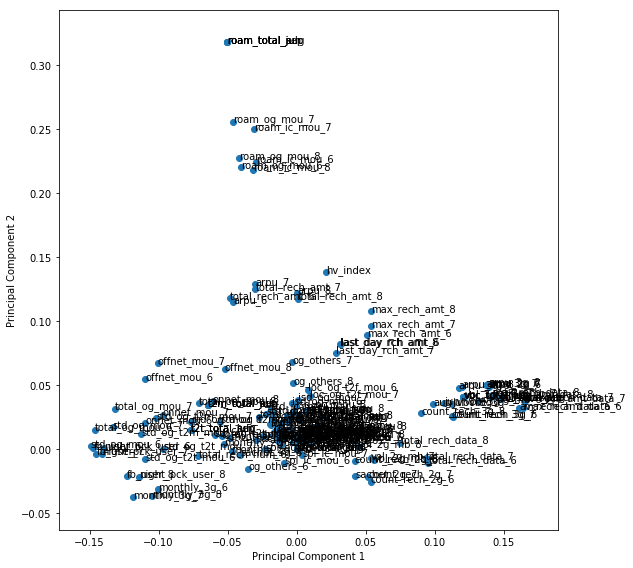

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

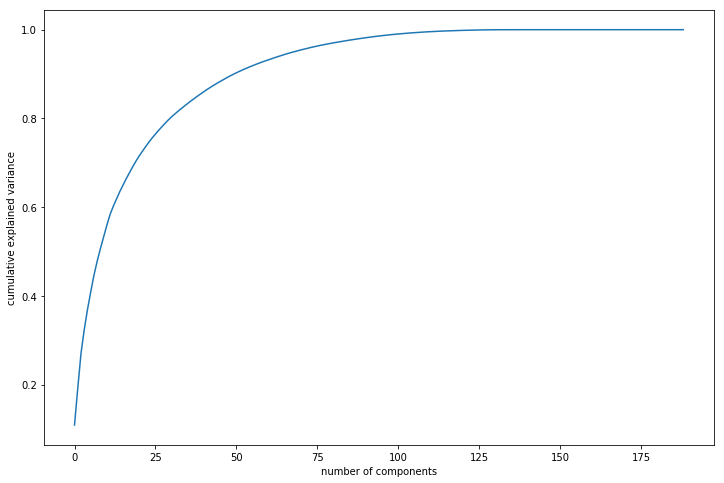

In [34]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [35]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=50)

In [36]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(38558, 50)

<Figure size 1440x720 with 0 Axes>

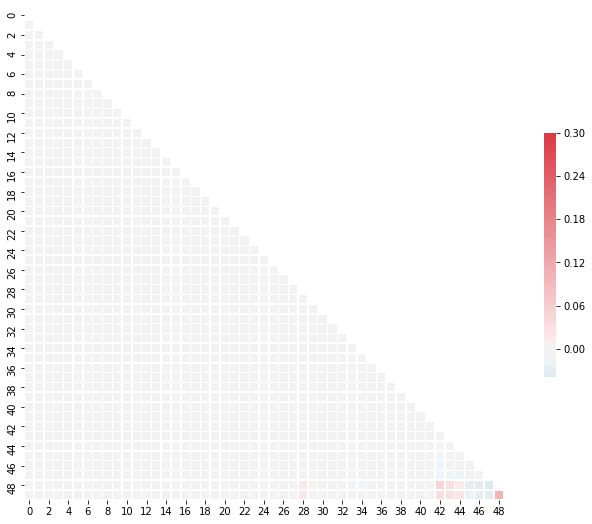

In [37]:
#creating correlation matrix for the principal components
corr = np.corrcoef(df_train_pca.transpose())
plt.figure(figsize = (20,10))
plot_triangular(corr)


In [39]:
# 1s -> 0s in diagonals
corr_nodiag = corr - np.diagflat(corr.diagonal())
print("max corr:",corr_nodiag.max(), ", min corr: ", corr_nodiag.min(),)

max corr: 0.10250313991243537 , min corr:  -0.03970938994674524


In [40]:
df_test_pca = pca_final.transform(X_test)

#### Run a plain logistic regression  with obtained component

In [41]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca_logistic = LogisticRegression()
model_pca_logistic = learner_pca_logistic.fit(df_train_pca,y_train)

In [42]:
#Making prediction on the test data
pred_probs_test = model_pca_logistic.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.9'

# 6. Model Evaluation
## 1. Logical Regression

In [48]:

churn_lr_pca = PCA(0.90)

#Transform the test and train 
churn_pca_train = churn_lr_pca.fit_transform(X_train)
churn_pca_test = churn_lr_pca.transform(X_test)

#training the regression model
chur_lr_pca_regressor = LogisticRegression()
lr_pca_model_2 = chur_lr_pca_regressor.fit(churn_pca_train,y_train)




#Making prediction on the test data
pred_probs_test2 = lr_pca_model_2.predict_proba(churn_pca_test)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test2))

'0.90'

## 2. SVM

In [49]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold

### 1. Linear Kernel
#### a. With PCA

In [54]:
churn_svm_pca_1 = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=100) 

#Train with PCAed train set which created in previous step
svm_pca_churn_model = churn_svm_pca_1.fit(churn_pca_train,y_train)

In [55]:
churn_svm_pca_pred_probs = svm_pca_churn_model.predict(churn_pca_test)
print("{:2.2f}".format(metrics.roc_auc_score(y_test, churn_svm_pca_pred_probs)))

0.84


#### b. With out PCA

In [56]:
churn_svm_model = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=100) 
svm_churn_model = churn_svm_model.fit(X_train,y_train)
churn_svm_pred_probs = churn_svm_model.predict(X_test)
print("{:2.2f}".format(metrics.roc_auc_score(y_test, churn_svm_pred_probs)))

0.97


## 3. Decision Trees

In [57]:
churn_dt_data = churn_data.copy()
# Putting feature variable to X
X = churn_dt_data.drop(['churn'],axis=1)

# Putting response variable to y
y = churn_dt_data['churn']
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [58]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [59]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97      8280
          1       0.68      0.54      0.61       720

avg / total       0.94      0.94      0.94      9000



In [60]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[8100  180]
 [ 329  391]]
0.9434444444444444


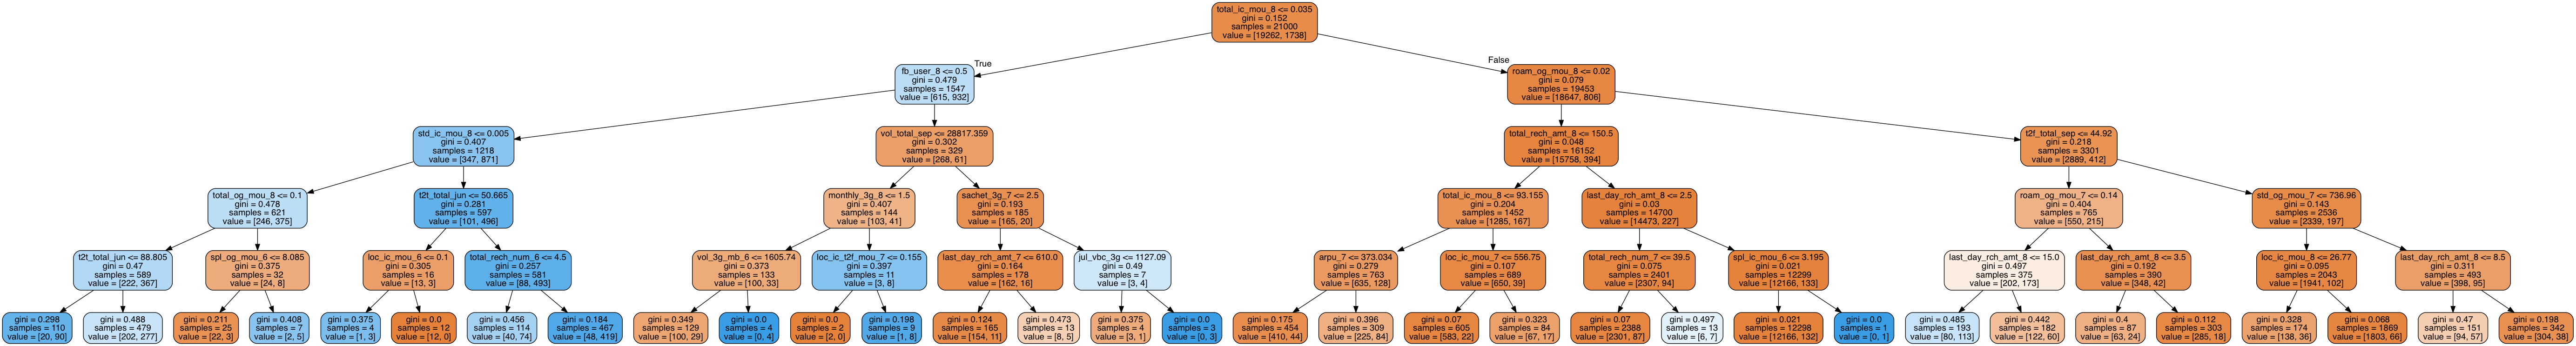

In [61]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot, graphviz

# Putting features
features = X.columns.values
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

In [62]:
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 40)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [63]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.181694      0.012708         0.003618        0.000691   
1       0.332177      0.002508         0.003482        0.000204   
2       0.503486      0.012925         0.003263        0.000176   
3       0.664454      0.015271         0.003729        0.000563   
4       0.875411      0.015565         0.003620        0.000082   

  param_max_depth            params  split0_test_score  split1_test_score  \
0               1  {'max_depth': 1}           0.933111           0.933111   
1               2  {'max_depth': 2}           0.942157           0.943109   
2               3  {'max_depth': 3}           0.942157           0.943109   
3               4  {'max_depth': 4}           0.942157           0.940252   
4               5  {'max_depth': 5}           0.940728           0.933111   

   split2_test_score  split3_test_score       ...         mean_test_score  \
0           0.929286           0.934746       ...                0.932286   
1           0.940714           0.945225       ...                0.942143   
2           0.940714           0.945225       ...                0.942143   
3           0.937381           0.943320       ...                0.940714   
4           0.937857           0.940938       ...                0.938476   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.001879               10            0.932139            0.932139   
1        0.001970                1            0.942199            0.941901   
2        0.001970                1            0.942378            0.941901   
3        0.002013                3            0.942378            0.942318   
4        0.002896                5            0.946187            0.945532   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.933095            0.931730            0.932623   
1            0.942560            0.941432            0.942861   
2            0.942560            0.941432            0.942861   
3            0.944048            0.943277            0.944110   
4            0.946964            0.947325            0.947325   

   mean_train_score  std_train_score  
0          0.932345         0.000470  
1          0.942190         0.000499  
2          0.942226         0.000505  
3          0.943226         0.000775  
4          0.946667         0.000703  

[5 rows x 21 columns]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


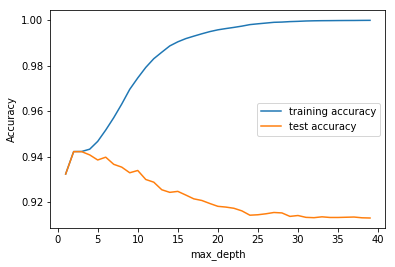

In [67]:
plot_accuracy(scores, parameters)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


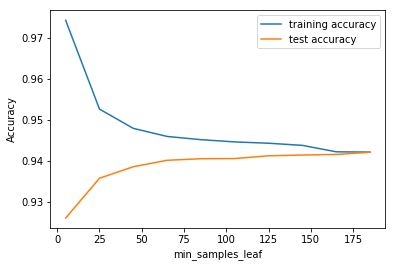

In [70]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)
plot_accuracy(tree.cv_results_, parameters)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


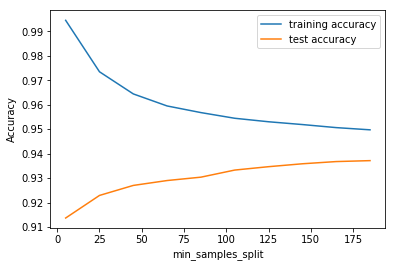

In [71]:
# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)
plot_accuracy(tree.cv_results_, parameters)

In [81]:
parameters = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = parameters, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)
#plot_accuracy(grid_search.cv_results_, parameters)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 15, 5), 'min_samples_leaf': range(50, 150, 50), 'min_samples_split': range(50, 150, 50), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [74]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

In [84]:
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.092382      0.035514         0.003546        0.000503   
1       1.069924      0.013237         0.003382        0.000169   
2       1.066783      0.007999         0.003769        0.000803   
3       1.058846      0.009764         0.003279        0.000201   
4       1.755604      0.033992         0.003278        0.000072   

  param_criterion param_max_depth param_min_samples_leaf  \
0         entropy               5                     50   
1         entropy               5                     50   
2         entropy               5                    100   
3         entropy               5                    100   
4         entropy              10                     50   

  param_min_samples_split                                             params  \
0                      50  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
1                     100  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
2                      50  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
3                     100  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
4                      50  {'criterion': 'entropy', 'max_depth': 10, 'min...   

   split0_test_score       ...         mean_test_score  std_test_score  \
0           0.938586       ...                0.939524        0.002577   
1           0.938586       ...                0.939524        0.002577   
2           0.940014       ...                0.940286        0.002263   
3           0.940014       ...                0.940286        0.002263   
4           0.936444       ...                0.938571        0.003262   

   rank_test_score  split0_train_score  split1_train_score  \
0                9            0.945294            0.943509   
1                9            0.945294            0.943509   
2                5            0.944878            0.943866   
3                5            0.944878            0.943866   
4               15            0.947080            0.947259   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.945476            0.943753            0.945718   
1            0.945476            0.943753            0.945718   
2            0.945060            0.942742            0.945658   
3            0.945060            0.942742            0.945658   
4            0.947381            0.945539            0.947027   

   mean_train_score  std_train_score  
0          0.944750         0.000927  
1          0.944750         0.000927  
2          0.944440         0.001027  
3          0.944440         0.001027  
4          0.946857         0.000671  

[5 rows x 24 columns]

##### Modeling with best hyper-paramete

In [75]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [76]:
# accuracy score
clf_gini.score(X_test,y_test)

0.9433333333333334

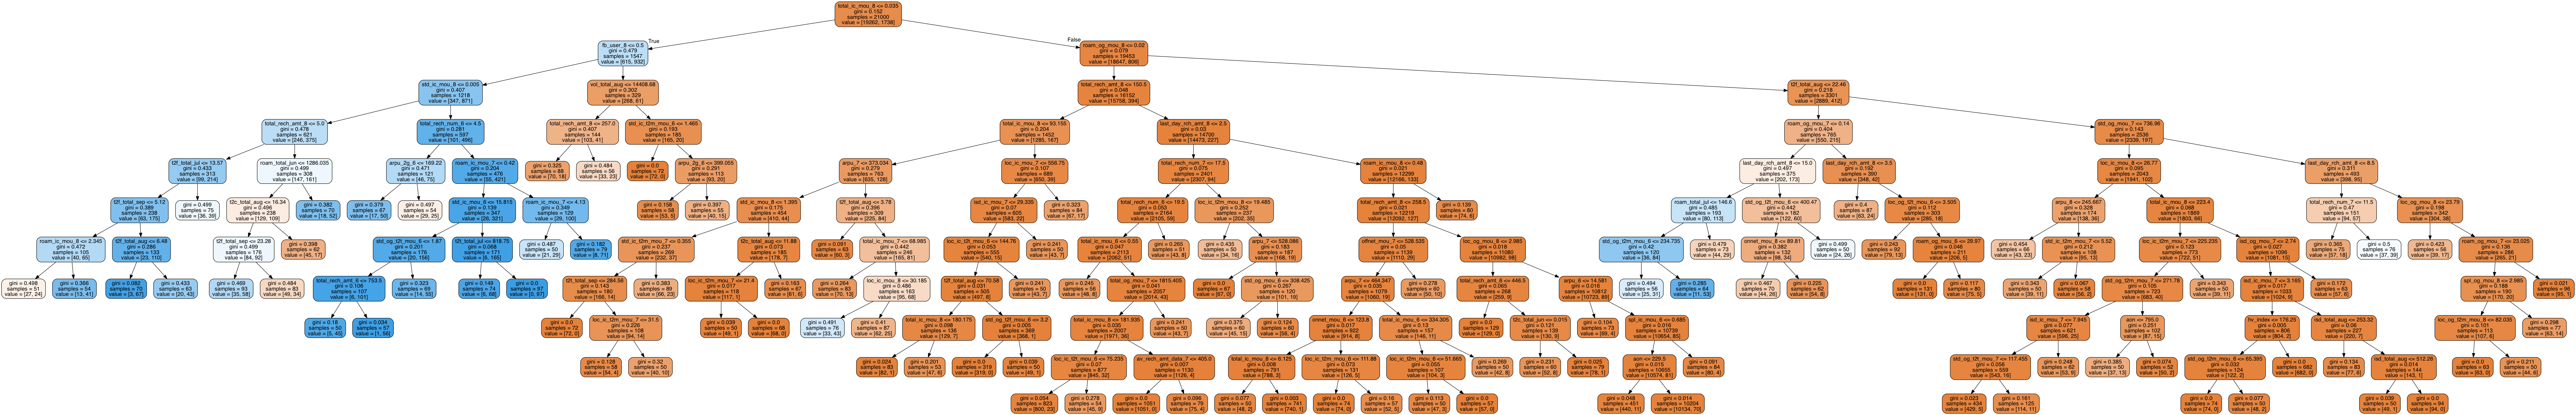

In [77]:
# plotting the tree
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

In [78]:
# tree with max_depth = 3
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=3, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

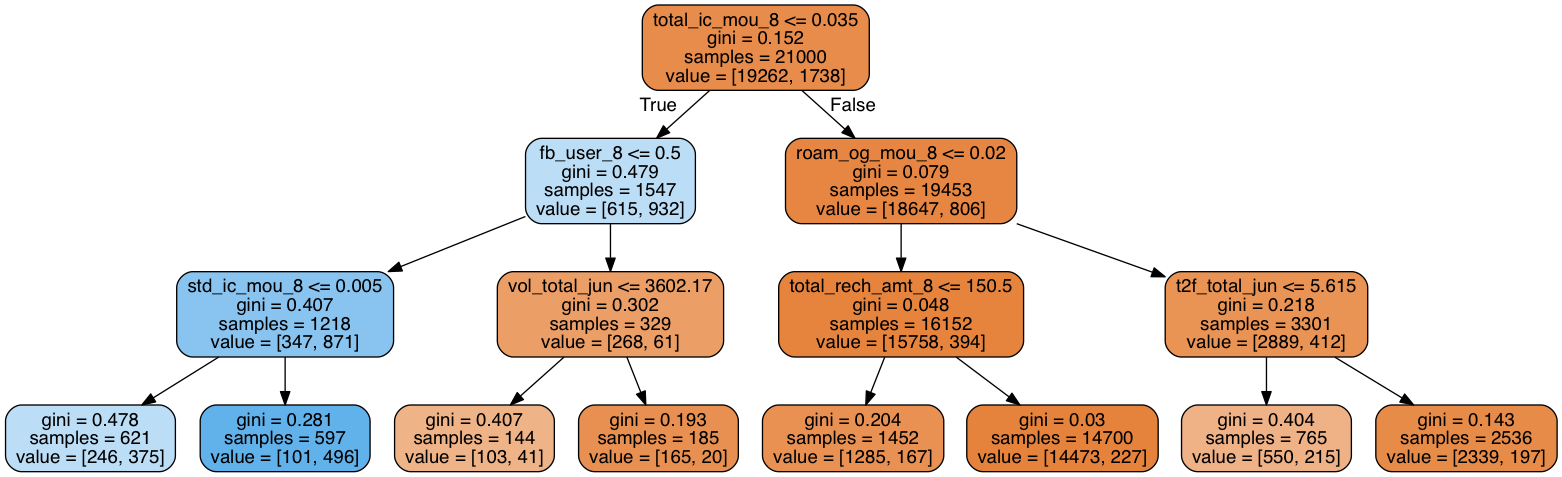

In [79]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

In [80]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix
y_pred = clf_gini.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97      8280
          1       0.71      0.49      0.58       720

avg / total       0.94      0.94      0.94      9000



In [82]:
y_pred = clf_gini.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97      8280
          1       0.71      0.49      0.58       720

avg / total       0.94      0.94      0.94      9000



In [83]:
# confusion matrix
print(confusion_matrix(y_test,y_pred))

[[8133  147]
 [ 366  354]]
